# Easc 305: Spatial Analysis (Part 3)  
---
# Kriging 

In [1]:
%matplotlib notebook 

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font',   size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes',   titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Demo 1: Experimental variograms

In [2]:
# x,y,z triplets
data = sio.loadmat('geost_dat.mat')
x    = data['x'][0:140].astype(np.float)
y    = data['y'][0:140].astype(np.float)
z    = data['z'][0:140].astype(np.float)

Plot data locations in $x$ and $y$, and inspect $z$ distribution  

<IPython.core.display.Javascript object>


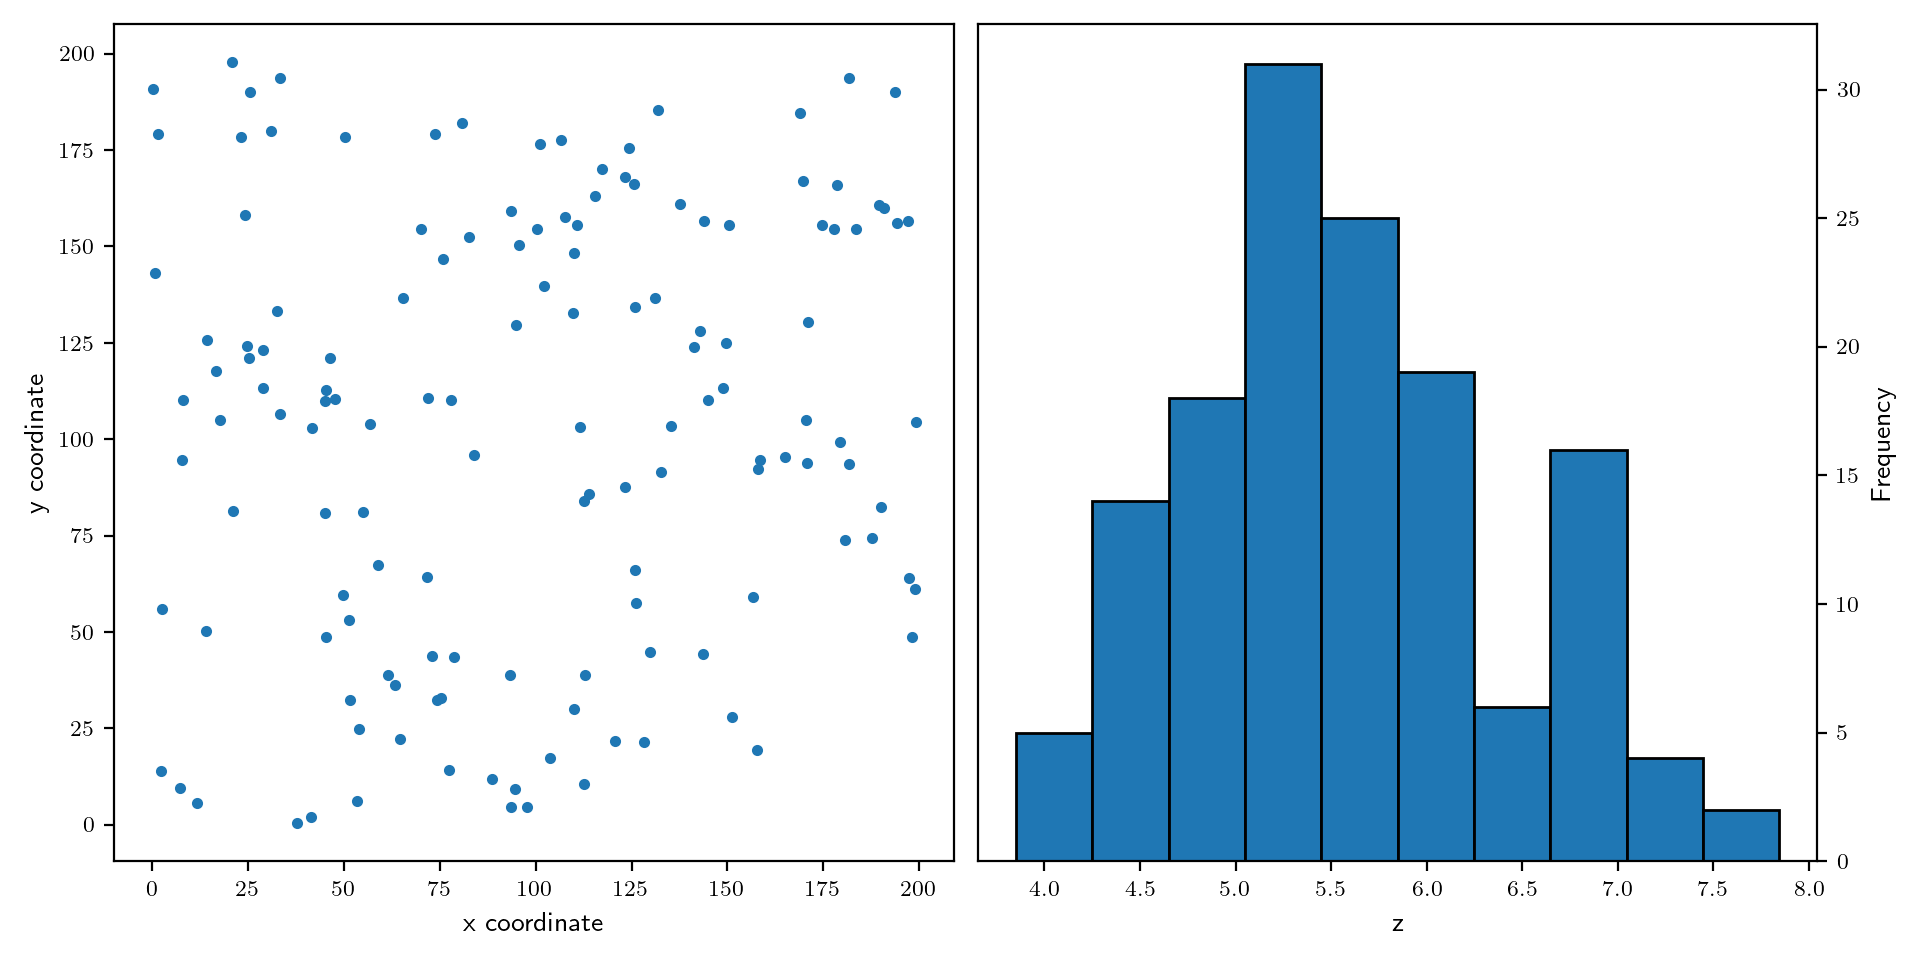

In [3]:
fig, ax = plt.subplots(1,2,figsize=(9.6,4.8))

ax[0].scatter(x,y,marker='.')
ax[0].set_ylabel('y coordinate')
ax[0].set_xlabel('x coordinate')

_ = ax[1].hist(z,edgecolor='k')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('z')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.tight_layout()

## Create Data Pairs

In [4]:
# Construct arrays that include all combinations of data pairs
X1, X2 = np.meshgrid(x,x)
Y1, Y2 = np.meshgrid(y,y)
Z1, Z2 = np.meshgrid(z,z)

To better understand what we are going to do, let's first create a simpler array `V` and visualize it:

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]

[[0. 1. 2. 3.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [3. 2. 1. 0.]]


<IPython.core.display.Javascript object>


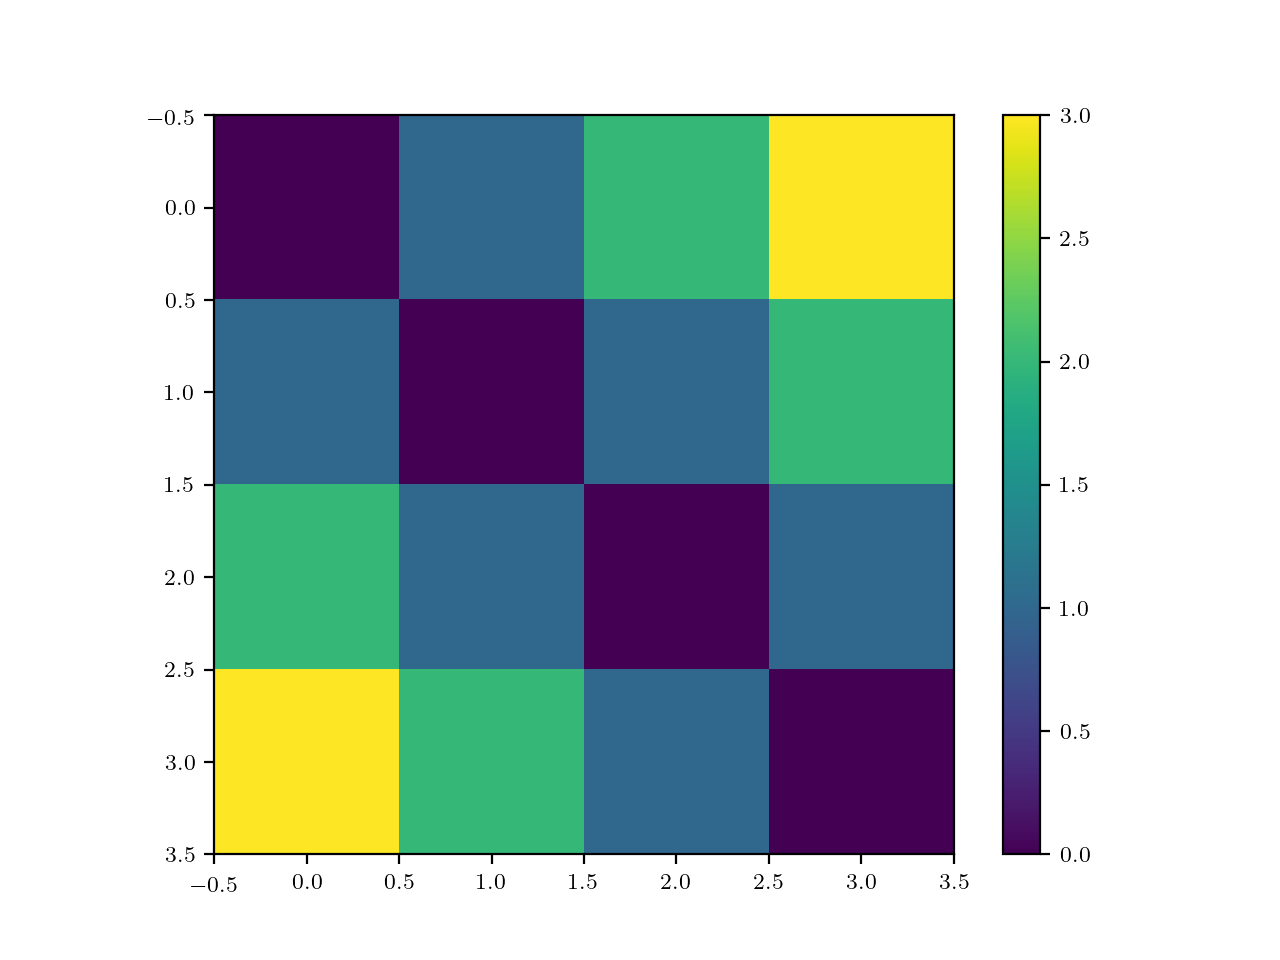

In [5]:
V = np.array([1,2,3,4])
V1, V2 = np.meshgrid(V,V)

print(V1)
print('')
print(V2)
print('')
print(np.sqrt((V1-V2)**2))

fig, ax = plt.subplots(1,1)
im = ax.imshow(np.sqrt((V1-V2)**2))
fig.colorbar(im,ax=ax);

## Compute separation distances ("lags") between all pairs:

In [6]:
D = np.sqrt( (X1-X2)**2 + (Y1-Y2)**2)

<IPython.core.display.Javascript object>


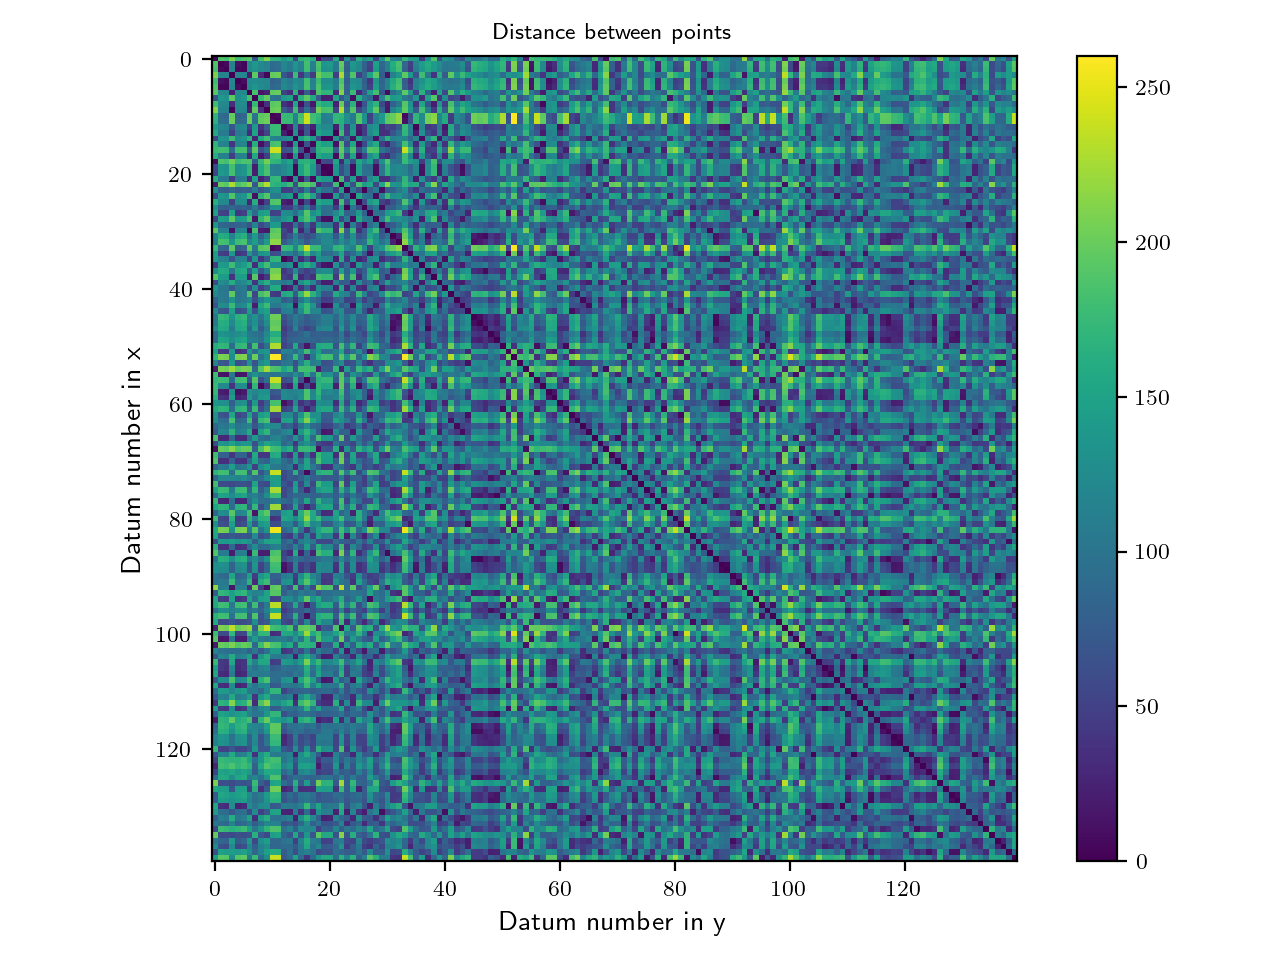

In [7]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(D)
ax.set_ylabel('Datum number in x')
ax.set_xlabel('Datum number in y')
ax.set_title('Distance between points')
fig.colorbar(im,ax=ax)

fig.tight_layout()

# Demo 3: Ordinary (punctual kriging)

We need to solve the equation: 

$$
\bf{W} {\Lambda} = B
$$

$$
\underbrace{
\begin{bmatrix}
    \gamma(x_1,x_1) & \gamma(x_1,x_2) & \gamma(x_1,x_3) & \ldots &  \gamma(x_1,x_k) & 1 \\
    \gamma(x_2,x_1) & \gamma(x_2,x_2) & \gamma(x_2,x_3) & \ldots &  \gamma(x_2,x_k) & 1\\
    \gamma(x_3,x_1) & \gamma(x_3,x_2) & \gamma(x_3,x_3) & \ldots &  \gamma(x_3,x_k) & 1 \\
    \vdots          &  \vdots         & \vdots          & \ddots &     \vdots       & \vdots \\
    \gamma(x_k,x_1) & \gamma(x_k,x_2) & \gamma(x_k,x_3) & \ldots & \gamma(x_k,x_k)  &  1\\
     1              &     1           &       1         &    1   & 1                & 0
    \end{bmatrix}
}_{\bf{W}} \;\;
%
\underbrace{
    \begin{bmatrix}
    \lambda_{1} \\
    \lambda_{2} \\
    \lambda_{3} \\
    \vdots \\
    \lambda_{3} \\
    \mu
    \end{bmatrix}
}_{\Lambda} =
%
\underbrace{
    \begin{bmatrix}
    \gamma(x_1,x_0) \\
    \gamma(x_2,x_0) \\
    \gamma(x_3,x_0) \\
    \vdots \\
    \gamma(x_k,x_0) \\
    1
    \end{bmatrix}
}_{B}
.
$$

for the weights $\Lambda$:
$$
\Lambda = \mathbf{W}^{-1} B 
\\
$$

We can then compute estimates of the variable $\hat z$ at unmeasured locations $x_0$: 
$$
\hat z(x_0) = Z^{\rm T} \Lambda
\\
$$

We can also compute the kriging variance (a measure of estimation uncertainty): 
$$
\sigma^2 = B^{\rm T} \Lambda
\\
$$

__Populate semivariance matrix W based on exponential model:__

In [8]:
# Suppose you have a fit an exponential model to your empirical semivariogram 
# and determined the following values for your best-fit parameters:
nugget   = 0.02
sill     = 0.68
range    = 45.
W        = nugget + sill*(1 - np.exp(-3*D/range)); # This equation defines the exponential model
print(W.shape)
print('')
print(W)
print('-----\n')

# Add extra row and column to W for Lagrange multiplier mu
m, n     = W.shape # m = number of rows, n = number of columns
W        = np.append(W,np.ones((1,m)),axis=0)   # Add final row of ones
print(W)
print('-----\n')
W        = np.append(W,np.ones((n+1,1)),axis=1) # Add final column of ones
print(W)
print('-----\n')
W[-1,-1] = 0
print(W)
print('')

(140, 140)

[[0.02       0.6999977  0.69999672 ... 0.69982437 0.69106657 0.69995952]
 [0.6999977  0.02       0.22707063 ... 0.69110023 0.69996585 0.6999983 ]
 [0.69999672 0.22707063 0.02       ... 0.68728662 0.69995303 0.69999792]
 ...
 [0.69982437 0.69110023 0.68728662 ... 0.02       0.69817076 0.6999773 ]
 [0.69106657 0.69996585 0.69995303 ... 0.69817076 0.02       0.69852523]
 [0.69995952 0.6999983  0.69999792 ... 0.6999773  0.69852523 0.02      ]]
-----

[[0.02       0.6999977  0.69999672 ... 0.69982437 0.69106657 0.69995952]
 [0.6999977  0.02       0.22707063 ... 0.69110023 0.69996585 0.6999983 ]
 [0.69999672 0.22707063 0.02       ... 0.68728662 0.69995303 0.69999792]
 ...
 [0.69106657 0.69996585 0.69995303 ... 0.69817076 0.02       0.69852523]
 [0.69995952 0.6999983  0.69999792 ... 0.6999773  0.69852523 0.02      ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
-----

[[0.02       0.6999977  0.69999672 ... 0.69106657 0.69995952 1.        ]
 [0.6999977  

In [9]:
# Invert matrix W for later
Winv = np.linalg.inv(W)

__Construct regular grid over which interpolated values are required:__

In [10]:
xgrid = np.arange(0,205,5)
ygrid = np.arange(0,205,5)
X, Y  = np.meshgrid(xgrid,ygrid)
print(X.shape)
print(Y.shape)

(41, 41)
(41, 41)


__Convert arrays to single vectors:__

In [11]:
Xvec = X.flatten()
Yvec = Y.flatten()
print(Xvec.shape)
print(Yvec.shape)

(1681,)
(1681,)


__Initialize variables:__

In [12]:
Zvec  = 99999.*np.ones((Xvec.shape[0],1))  # Vector of kriging estimates
S2vec = 99999.*np.ones((Xvec.shape[0],1))  # Vector of kriging variances

__Computed kriged estimate at each location `i`:__

In [13]:
#Computed kriged estimate at each point i
for i in np.arange(Xvec.shape[0]):
    # calculate distances between point of interest and all observations:
    D0 = np.sqrt( (x - Xvec[i])**2 + (y - Yvec[i])**2 )
    # calculate B (RHS) based on distances D0 above and variogram model
    B = nugget + sill*(1 - np.exp(-3*D0/range))
    # Add final element for Lagrange multiplier
    B = np.append(B,1)
    # Compute kriging weights and Lagrange multiplier with matrix multiplication
    Lambda   = np.dot(Winv,B)
    # Compute kriging estimate at point of interest as weighted sum of observations 
    Zvec[i]  = np.dot(z.T,Lambda[:n]) # Omit final element of Lambda (Lagrange multiplier)
    # Compute kriging variance at point of interest
    S2vec[i] = np.dot(B.T,Lambda)

# Reshape results and plot  
M  = xgrid.shape[0]
Z  = Zvec.reshape(M,M)
S2 = S2vec.reshape(M,M)

__Plot the results:__ 

<IPython.core.display.Javascript object>


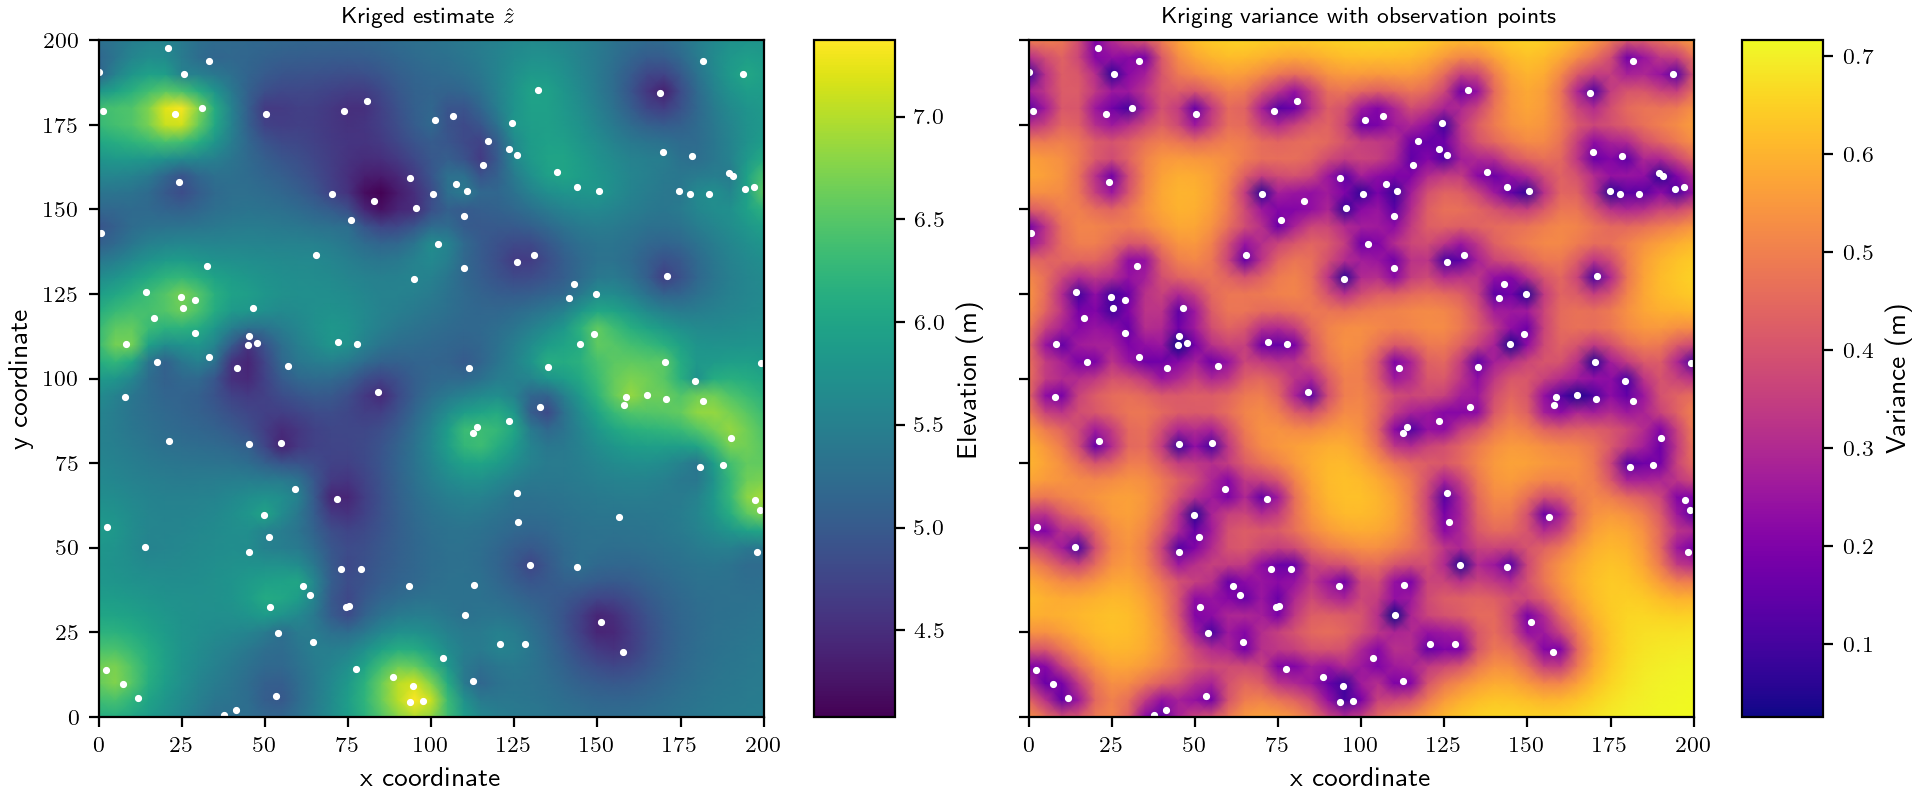

In [14]:
fig, ax = plt.subplots(1,2,figsize=(9.6,4.0),sharex=True, sharey=True, constrained_layout=True)

im = ax[0].pcolormesh(X,Y,Z, shading='gouraud')
ax[0].scatter(x,y,marker='.',c='white',s=10)

fig.colorbar(im,ax=ax[0], label='Elevation (m)')
ax[0].set_title('Kriged estimate $\hat z$')
ax[0].set_ylabel('y coordinate')
ax[0].set_xlabel('x coordinate')

im = ax[1].pcolormesh(X,Y,S2,cmap='plasma',shading='gouraud')
ax[1].scatter(x,y,marker='.',c='white',s=10)

fig.colorbar(im,ax=ax[1], label='Variance (m)')
ax[1].set_title('Kriging variance with observation points')
ax[1].set_xlabel('x coordinate')
ax[1].set_xlim(0,200);